In [ ]:
# https://drive.google.com/file/d/1IHdxHKthYDHcN_zx9Pxon2qKCtpdb2ni/view?usp=sharing
!gdown --id 1IHdxHKthYDHcN_zx9Pxon2qKCtpdb2ni
!unzip Aloe_images.zip

/usr/local/lib/python3.8/dist-packages/gdown/cli.py:127: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1IHdxHKthYDHcN_zx9Pxon2qKCtpdb2ni
To: /content/Aloe_images.zip
100% 1.32M/1.32M [00:00<00:00, 116MB/s]
Archive:  Aloe_images.zip
replace Aloe/Aloe_left_1.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: Aloe/Aloe_left_1.png    
  inflating: Aloe/Aloe_right_3.png   
  inflating: Aloe/Aloe_right_1.png   
  inflating: Aloe/Aloe_right_2.png   
  inflating: Aloe/Disparity_map_corr.png  


- Mục tiêu bài học: Đi tìm độ sâu của 2 camera (dùng 2 camera để lấy thông tin). Robot muốn di chuyển tự động thì cần có thông tin độ sâu để biết chướng ngại vật để né.

> Văn bản được thụt lề



- Monodepth: Tìm độ sâu chỉ bằng 1 camera (nhắm mắt 1 bên vẫn đi được, tuy nhiên đến 1 vùng mới thì sẽ rất khó để đi).
- Uber năm 2019 sử dụng Monodepth + Lidar.
- Tesla theo xu hướng dùng 2 camera. Có 2 nguyên nhân: Thứ 1, là về mặt kinh tế muốn bán nhiều xe. Thứ 2 là họ rất giỏi vì mời được Karpathy về làm.

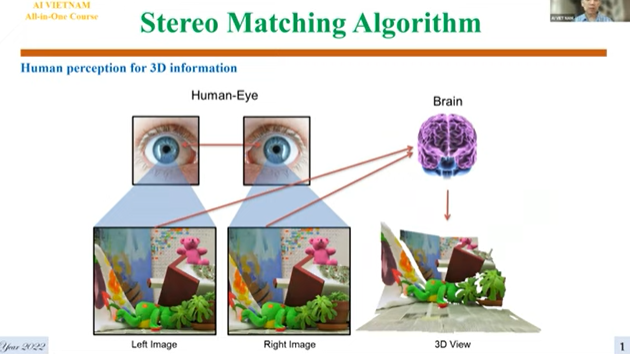

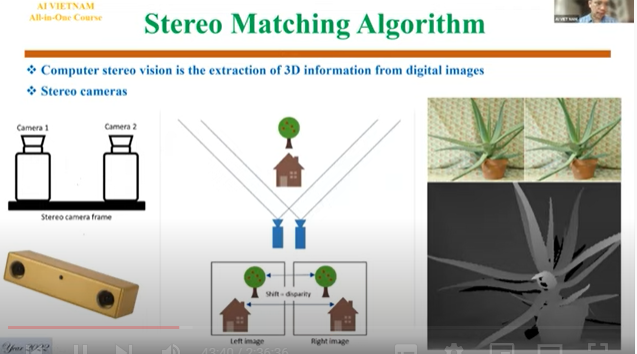

- Disparity: Độ lệch
- Free space: 

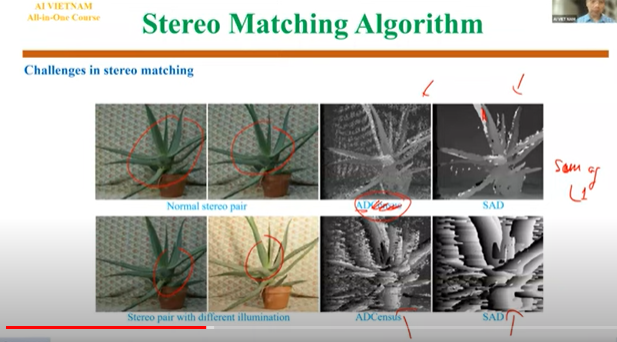

- Khó khăn trong lĩnh vực: 
  - Camera trái và phải thường không đồng nhất với nhau.
  - Camera bị chói, không thiết kế cho buổi tối.

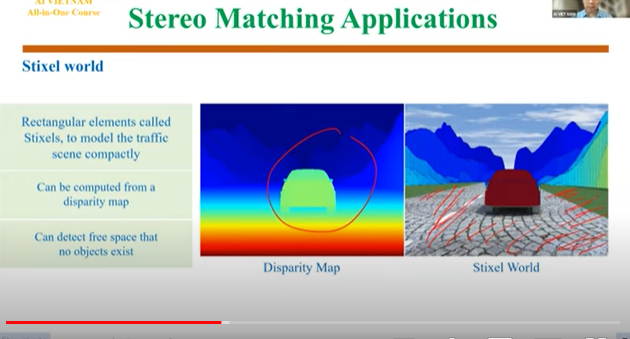

- Hiện tại người ta dùng Segmentation cho các ứng dụng liên quan đến xe.


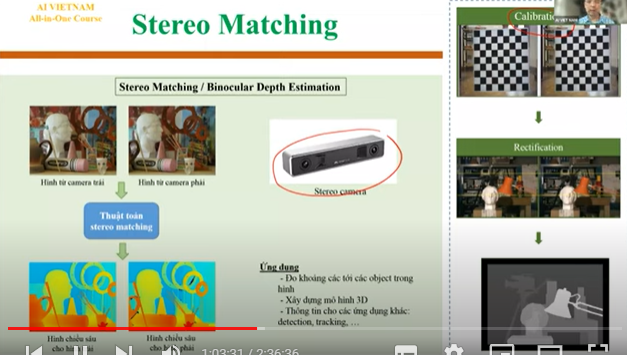

- 2 điểm tương ứng ảnh trái và ảnh phải nằm trên cùng 1 dòng. (Calibration->Rectification)

- Tính chất ảnh đã được Rectification:
 - 

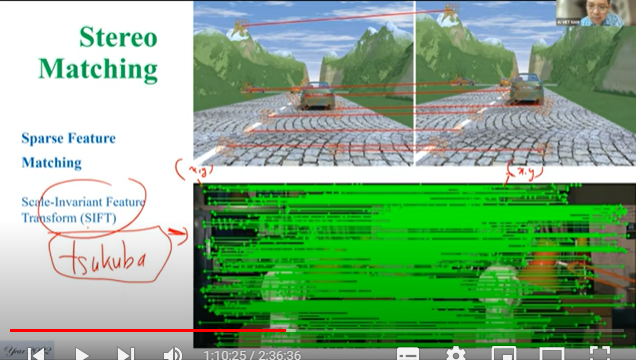

- Khi tìm được các điểm tương ứng thì thuật toán sẽ trả về tọa độ x, y của điểm 1 và x,y của điểm tương ứng rồi lấy 2 giá trị x1 - x2 xem độ lệch bằng bao nhiêu (disparity). Nhược điểm:

> Văn bản được thụt lề



# Problem 1

In [ ]:
import cv2
import numpy as np

def l1_distance(x, y): #ảnh trái 
  return abs(x - y)

def l2_distance(x, y): #ảnh phải
  return (x - y) ** 2

def pixel_wise_matching(left_img, right_img, disparity_range, compute_type='l1', save_result=True):
  # đọc ảnh trái và ảnh phải, rồi chuyển sang ảnh grayscale
  left  = cv2.imread(left_img, 0)    
  right = cv2.imread(right_img, 0) 

  left  = left.astype(np.float32)
  right = right.astype(np.float32) 

  height, width = left.shape[:2]
  
  # tạo disparity map
  depth = np.zeros((height, width), np.uint8)               
  scale = 255 / disparity_range 

  print(f'Compute disparity map using pixel-wise matching with {compute_type.upper()}...')

  if compute_type == 'l1':
    max_value = 255
    distance = l1_distance
  elif compute_type == 'l2':
    max_value = 255 ** 2
    distance = l2_distance
  else:
    print("Compute type not supported! Please choose either 'l1' or 'l2'!")
    return

  for y in range(height):        
    for x in range(width):
        
      # tìm j tại đó cost có giá trị min
      disparity = 0
      cost_min  = max_value
        
      for j in range(disparity_range):                
        cost = max_value if (x - j) < 0 else distance(int(left[y, x]), int(right[y, x - j]))
        
        if cost < cost_min:
          cost_min  = cost
          disparity = j
                      
      # đã tìm được j (lưu ở biến disparity) để cost min
      # gán j đó vào disaprity map
      # nhân cho scale để nhìn thấy rõ ràng (không cần scale cũng được)
      depth[y, x] = disparity * scale
  
  if save_result == True:
    print('Saving result...')
    # chuyển dữ liệu từ ndarray sang kiểu Image và lưu xuống file
    cv2.imwrite(f'pixel_wise_{compute_type}.png', depth)
    cv2.imwrite(f'pixel_wise_{compute_type}_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

  print('Done.')

  return depth

Compute disparity map using pixel-wise matching with L2...
Saving result...
Done.


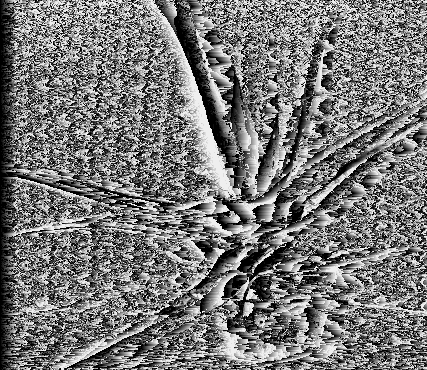

In [ ]:
from google.colab.patches import cv2_imshow

left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_1.png'
disparity_range = 16 

pixel_wise_result = pixel_wise_matching(left_img_path, right_img_path, disparity_range, compute_type='l2', save_result=True)
cv2_imshow(pixel_wise_result)

# Problem 2

In [ ]:
import cv2
import numpy as np

def l1_distance(x, y):
  return abs(x - y)

def l2_distance(x, y):
  return (x - y) ** 2

def window_based_matching(left_img, right_img, disparity_range, compute_type='l1', kernel_size=5, save_result=True):
  # đọc ảnh trái và ảnh phải, rồi chuyển sang ảnh grayscale
  left  = cv2.imread(left_img, 0)    
  right = cv2.imread(right_img, 0)  
  
  left  = left.astype(np.float32)
  right = right.astype(np.float32)

  height, width = left.shape[:2]
  
  # tạo disparity map
  depth = np.zeros((height, width), np.uint8)               
  scale = 255 / disparity_range 

  print(f'Compute disparity map using window-based matching with {compute_type.upper()}...')

  if compute_type == 'l1':
    max_value = 255
    distance = l1_distance
  elif compute_type == 'l2':
    max_value = 255 ** 2
    distance = l2_distance
  else:
    print("Compute type not supported! Please choose either 'l1' or 'l2'!")
    return

  kernel_half = int((kernel_size - 1) / 2)
  scale = 255 / disparity_range
    
  for y in range(kernel_half, height-kernel_half + 1):  

    for x in range(kernel_half, width-kernel_half + 1):
        
      # tìm j tại đó cost có giá trị min
      disparity = 0
      cost_min  = max_value
      
      for j in range(disparity_range): 
        ssd = 0
        ssd_temp = 0 
        
        for v in range(-kernel_half, kernel_half):
          for u in range(-kernel_half, kernel_half):
            ssd_temp = max_value
            if (x + u - j) >= 0:
              ssd_temp = distance(int(left[y + v, x + u]),  int(right[y + v, (x + u) - j]))
            ssd += ssd_temp         
        
        if ssd < cost_min:
          cost_min = ssd
          disparity = j
        
        # gán j cho cost_min vào disaprity map
        depth[y, x] = disparity * scale
  
  if save_result == True:
    print('Saving result...')
    # chuyển dữ liệu từ ndarray sang kiểu Image và lưu xuống file
    cv2.imwrite(f'window_based_{compute_type}.png', depth)
    cv2.imwrite(f'window_based_{compute_type}_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

  print('Done.')

  return depth

Compute disparity map using window-based matching with L2...
Saving result...
Done.


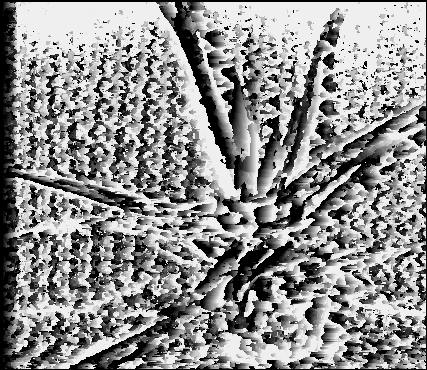

In [ ]:
from google.colab.patches import cv2_imshow

left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_1.png'
disparity_range = 16
kernel_size = 5

window_based_result = window_based_matching(left_img_path, right_img_path, disparity_range, compute_type='l2', kernel_size=kernel_size, save_result=True)
cv2_imshow(window_based_result)

# Problem 3
**Answer:** độ đo L1 và L2 không có tính chất 'invariant to linear changes' (như cosine similarity và correlation coefficient). Do đó, L1 L2 sẽ không thể hoạt động tốt với hai ảnh cùng nội dung nhưng có một chút khác biệt liên quan đến độ sáng...

Compute disparity map using window-based matching with L2...
Done.


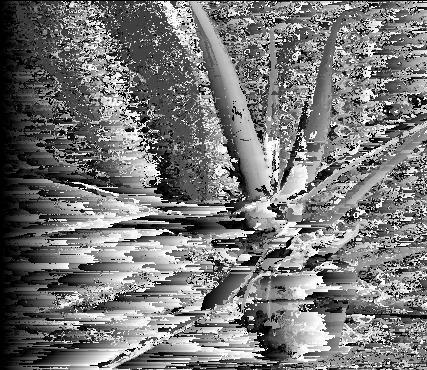

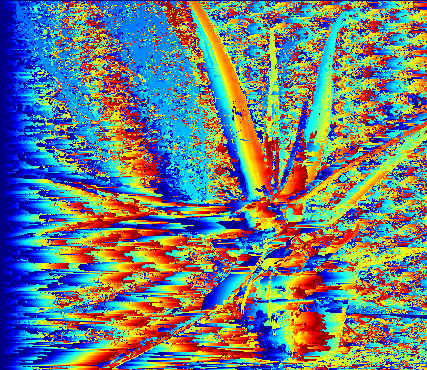

In [ ]:
from google.colab.patches import cv2_imshow

left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_3.png'
disparity_range = 64
kernel_size = 3

result = window_based_matching(left_img_path, right_img_path, disparity_range, compute_type='l2', kernel_size=kernel_size, save_result=False)
cv2_imshow(result)
cv2_imshow(cv2.applyColorMap(result, cv2.COLORMAP_JET))

# Problem 4

In [ ]:
import cv2
import numpy as np

from numpy.linalg import norm


def cosine_similarity(x, y):
  numerator = np.dot(x, y)
  denominator = norm(x) * norm(y)

  return numerator / denominator

def window_based_matching(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
  # đọc ảnh trái và ảnh phải, rồi chuyển sang ảnh grayscale
  left  = cv2.imread(left_img, 0)    
  right = cv2.imread(right_img, 0)  

  left  = left.astype(np.float32)
  right = right.astype(np.float32)

  height, width = left.shape[:2]
  
  # tạo disparity map
  depth = np.zeros((height, width), np.uint8)               
  scale = 255 / disparity_range 

  print('Compute disparity map using window-based matching with cosine similarity...')

  kernel_half = int((kernel_size - 1) / 2)
  scale = 255 / disparity_range
    
  for y in range(kernel_half, height-kernel_half):  

    for x in range(kernel_half, width-kernel_half):
        
      # tìm j tại đó cost có giá trị min
      disparity = 0
      cost_optimal  = -1
      
      for j in range(disparity_range): 
        d = x - j 

        cost = -1
        if (d - kernel_half) > 0:
          wp = left[(y-kernel_half):(y+kernel_half)+1, (x-kernel_half):(x+kernel_half)+1]
          wqd = right[(y-kernel_half):(y+kernel_half)+1, (d-kernel_half):(d+kernel_half)+1]

          wp_flattened = wp.flatten()
          wqd_flattened = wqd.flatten()

          cost = cosine_similarity(wp_flattened, wqd_flattened)     

        if cost > cost_optimal:
          cost_optimal = cost
          disparity = j
        
        # gán j cho cost_min vào disaprity map
        depth[y, x] = disparity * scale
  
  if save_result == True:
    print('Saving result...')
    # chuyển dữ liệu từ ndarray sang kiểu Image và lưu xuống file
    cv2.imwrite('window_based_cosine_similarity.png', depth)
    cv2.imwrite('window_based_cosine_similarity_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

  print('Done.')

  return depth

Compute disparity map using window-based matching with cosine similarity...
Saving result...
Done.


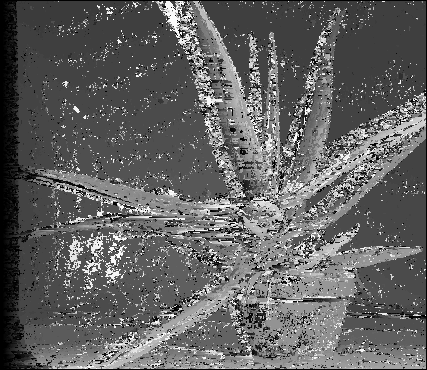

In [ ]:
from google.colab.patches import cv2_imshow

left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_3.png'
disparity_range = 64
kernel_size = 3

result = window_based_matching(left_img_path, right_img_path, disparity_range, kernel_size=kernel_size, save_result=True)
cv2_imshow(result)

# Problem 5

In [ ]:
import cv2
import numpy as np

from numpy.linalg import norm
from scipy.stats import pearsonr

def correlation_coefficient(x, y):
  n = x.size
  numerator = (n * np.dot(x, y)) - (np.sum(x) * np.sum(y))
  denominator = np.sqrt((n * np.sum(x ** 2)) - (np.sum(x) ** 2)) * np.sqrt((n * np.sum(y ** 2)) - (np.sum(y) ** 2))

  return numerator / denominator

def window_based_matching(left_img, right_img, disparity_range, kernel_size=5, save_result=True):
  # đọc ảnh trái và ảnh phải, rồi chuyển sang ảnh grayscale
  left  = cv2.imread(left_img, 0)    
  right = cv2.imread(right_img, 0)  

  left  = left.astype(np.float32)
  right = right.astype(np.float32)

  height, width = left.shape[:2]
  
  # tạo disparity map
  depth = np.zeros((height, width), np.uint8)               
  scale = 255 / disparity_range 

  print('Compute disparity map using window-based matching with correlation coefficient...')

  kernel_half = int((kernel_size - 1) / 2)
  scale = 255 / disparity_range
    
  for y in range(kernel_half, height-kernel_half):  

    for x in range(kernel_half, width-kernel_half):
        
      # tìm j tại đó cost có giá trị min
      disparity = 0
      cost_optimal  = -1

      for j in range(disparity_range): 
        d = x - j 
        cost = -1
        if (d - kernel_half) > 0:
          wp = left[(y-kernel_half):(y+kernel_half)+1, (x-kernel_half):(x+kernel_half)+1]
          wqd = right[(y-kernel_half):(y+kernel_half)+1, (d-kernel_half):(d+kernel_half)+1]

          wp_flattened = wp.flatten()
          wqd_flattened = wqd.flatten()

          cost = correlation_coefficient(wp_flattened, wqd_flattened)

        if cost > cost_optimal:
          cost_optimal = cost
          disparity = j
        
        # gán j cho cost_min vào disaprity map
        depth[y, x] = disparity * scale
  
  if save_result == True:
    print('Saving result...')
    # chuyển dữ liệu từ ndarray sang kiểu Image và lưu xuống file
    cv2.imwrite('window_based_corrcoef.png', depth)
    cv2.imwrite('window_based_corrcoef_color.png', cv2.applyColorMap(depth, cv2.COLORMAP_JET))

  print('Done.')

  return depth

Compute disparity map using window-based matching with correlation coefficient...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


Saving result...
Done.


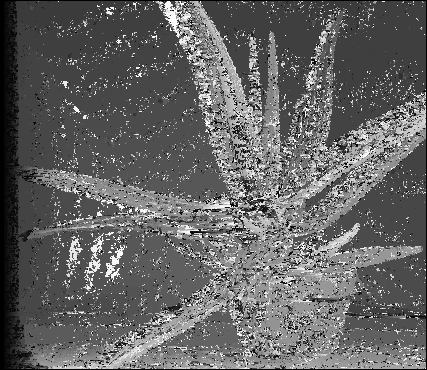

In [ ]:
from google.colab.patches import cv2_imshow

left_img_path = 'Aloe/Aloe_left_1.png'
right_img_path = 'Aloe/Aloe_right_3.png'
disparity_range = 64
kernel_size = 3

result = window_based_matching(left_img_path, right_img_path, disparity_range, kernel_size=kernel_size, save_result=True)
cv2_imshow(result)